<div class="alert alert-danger" role="alert">
<h2> Important information </h2><br>

This is a version of the notebook with the solutions to the challenges.
> Make sure to finish the "student" version first.
    
At the end of the second and third chapter, you will find workgroup assignments in GREEN font color.
    
> The three prespecified assignments will sum up to 100 points. You need a minumum of 50 points for a passing grade.
    
> For individual assignment, make sure to discuss with the workgroup teacher!
    
</div>


# Reinforcement Learning in bandit tasks and gridworlds

Steven Miletic<br>
<sub>Leiden University<sub><br><br>  
    
This is the code for the practical session in the course "2425-S1 Cognitive Modelling: How to build a brain" [(link to Brightspace)](https://brightspace.universiteitleiden.nl/d2l/home/309838)<br>   
Date: September 30th 2024<br>

Code based on [Franz Wurm's version of last year](https://github.com/fwurm/teaching_CognitiveModelling)

**Useful references**
- Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.

# 1. Overview

### 1.1 Goal of this practical

In this practical, you are going to implement a reinforcement learning agent for a standard decision-making problem as often used in psychological experiments. Our agent will be learn the value of states and actions in the environment simply by observing their associated rewards and punishments. As discussed in the lecture, this resembles the principles of classical and operant conditioning. It is a efficient way of learning that leads to simple, habitual behavioral patterns.

Step by step, we will discuss the different necessary components to realize such a reinforcement learning agent.

### 1.2 Setting up this notebook 

This notebook contains all necessary information for the first practical session. The exercise is intended to be completed chronologically, i.e. from top to bottom. It includes blocks of text with explanations and code blocks to execute commands and code, including code blocks where you need to add your code.

A few recommendations:
- I recommend to download the file and save it to a separate folder. Ideally, this folder is easily accessible (e.g. on your desktop) or implemented in a preexisting folder structure (e.g. MyBachelor>CogMod>PracticalRL).
- I also recommend to work with copies. That means, don't work on the original file, but rather work on a copy. This makes sure that you do not delete important information and always have a basis to go back to. Additionally, you could implement version control, meaning you save your work to a new file from time to time (e.g., filename_v1, filename_v2). This makes sure you dont lose too much progress in case your computer shuts down or you forgot to press the save button.
- For working on the excersises of the practical I suggest you use [Google Colab](https://colab.research.google.com/) or [Jupyter-notebook](https://jupyter.org/). While Google Colab is straight-foward to use, Jupyter-notebook might require you to install additional software (e.g., [Anaconda](https://anaconda.org/)).


In [54]:
# first, let's import some packages that we need

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. A simple k-armed bandit task

In the [bandit problem](https://en.wikipedia.org/wiki/Multi-armed_bandit), the agent is faced with a choice between $k$ multiple options. Named after slot machines in a casino, our one and two-armed versions in the lecture were used to demonstrate the two core principles that allow the agent to achieve his goal of reward maximzation.

First, we'll simulate 'drawing' or 'sampling' from a bandit in a function -- i.e., we simulate pulling the lever of a slot machine. To simulate a slot machine, we need to specify how often the slot machine gives out a reward. That means that we need to specify the _reward distribution_, which is a probability distribution.

The functions below uses a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). That is, on every draw, the bandit/slot machine either gives a reward, or not. The probability of reward is user-specified, and given by the argument <code>prob</code>.

In [55]:
def draw_from_one_bandit(n_trials, prob):
    
    reward_samples = np.random.binomial(1,prob,n_trials)  # this simulates the rewards
    
    return reward_samples

def draw_from_k_bandits(n_trials, probs):
    
    n_bandits = len(probs)  # how many arms?
    
    # preallocate output
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))
    
    for i, prob in enumerate(probs):
        reward_samples[i,:] = draw_from_one_bandit(n_trials, prob)
        reward_probs[i,:] = prob
        
    return reward_samples, reward_probs

<div class="alert alert-warning" role="alert">
<h2> 2.1 Let's try it out! </h2><br>

Generate two bandits with each 100 trials. The bandits should have reward probabilities of 80% and 20%, respectively.

Verify that the simulated reward probabilities are indeed 80% and 20%. (hint: <code>np.mean()</code> can easily calcuate the mean)

Try to write efficient code (few lines)!
    
</div>


In [56]:
## TODO: create bandits and print average reward

n_trials = 100
probs = [0.8, 0.2]

reward_samples, reward_probs = draw_from_k_bandits(n_trials, probs)

print(reward_samples)
print(f'mean: {np.mean(reward_samples,axis=1)}')

[[1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.
  0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]]
mean: [0.86 0.17]


### Learning and deciding
As discussed in the lecture, the two principles of reinforcement learning are
- the learning rule: _updating_ of expectations based on observations 
- the decision rule: taking _actions_ based on expectations

Below, we'll first try out different learning rules.

## 3. The learning rule

The learning rule should help our agent to build up expectations about its environment.

In this section, we are going to demonstrate why a _weighted-average_ method outperforms the _average_ method in changing environments.

#### 3.1 Calculating the average

As a first step, let us have a look at the performance of the averaging method for incremental learning in a stable environment.

We specify the learning rule for incremental averaging in acordance with the formula introduced in the lecture.

$V_{t+1} = V_{t} + \frac{1} {t}(R_{t} - V_{t})$,

>where $V$ is the estimated average value,<br>
>and $t$ is the current time step.<br>

The code below implements the incremental average method in a 'static' environment (i.e., the reward probabilities don't change across time)

In [57]:
n_trials = 1000
prob = [0.7]

reward_samples, reward_probs = draw_from_k_bandits(n_trials,prob)

mean_avg = np.empty((1,n_trials+1))   # Pre-allocate an array in which we'll store the running averages
for iT in np.arange(n_trials):
    if iT == 0:
        mean_avg[0,0] = 0.5     ## Think about this for a moment: what are we doing here?
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[0,iT]-mean_avg[0,iT])

<div class="alert alert-warning" role="alert">
<h2> 3.2 Challenge </h2><br>

Show that the incremental average mean indeed converges to the true reward probability.
    
>Use the <code>print</code> function and the matplotlib methods, loaded as <code>plt</code> to visualize the values obtained from the average method across trials
</div>

true value: 0.700000
average value of samples: 0.704000
estimate of value after 1000 samples: 0.704000


Text(0, 0.5, 'estimated reward')

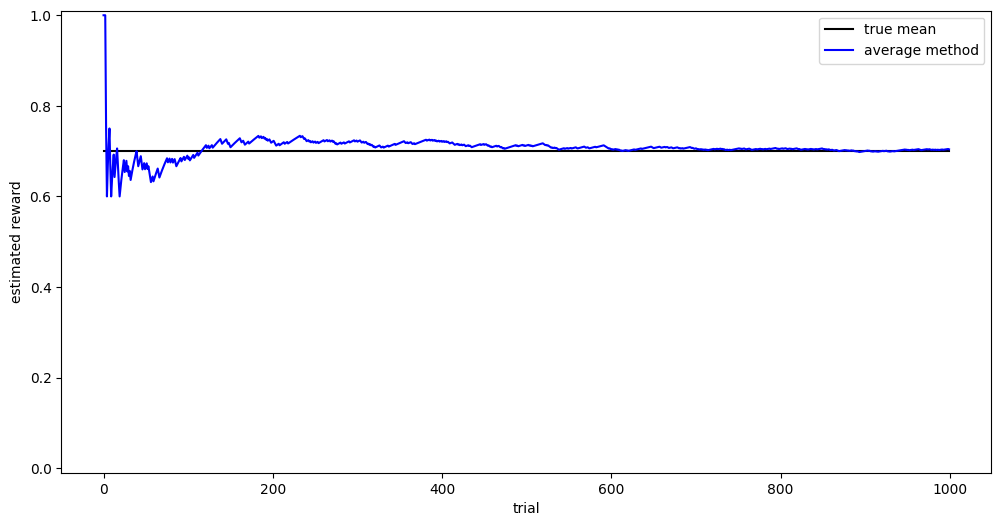

In [58]:
#print(np.arange(n_trials))    
#print(reward_samples)
#print(reward_probs)

print('true value: %f' % np.mean(reward_probs))
print('average value of samples: %f' % np.mean(reward_samples))
print('estimate of value after 1000 samples: %f' % mean_avg[0,-1])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(np.arange(n_trials),reward_probs[0,:],'-k',label = 'true mean')
ax.plot(np.arange(n_trials),mean_avg[0,1:],'-b',label ='average method')
ax.set_ylim([-0.01,1.01])
plt.legend(loc="upper right")  
ax.set_xlabel('trial')
ax.set_ylabel('estimated reward')

#### 3.3 ...in changing environments

So far, that looks great -- the average method of incremental learning does a good job in estimating the average on a step-by-step basis. However, what happens if the environment is not stable? By 'unstable' or 'changing' environments, we mean environments in which the reward probabilities change across trials.

Below, the code simulates a changing environment by drawing 1000 samples from a bandit with 70% reward probability, followed by 1000 samples with 30% reward probability, followed by another 1000 trials with 70% reward probability, etc. The _average_ method is used to estimate the value of the bandit.

In [59]:
n_trials = 1000
probs = [0.7, 0.3, 0.7, 0.3, 0.7, 0.3]

reward_samples, reward_probs = draw_from_k_bandits(n_trials,probs)

# Simulate a bandit with changing reward probabilities by
# flattening a m-by-n matrix into a 1-by-m*n vector
reward_samples = reward_samples.flatten()
reward_probs = reward_probs.flatten()
# this problem could also be solved by multiple loops

mean_avg = np.empty((1,len(reward_probs)+1))
for iT in np.arange(len(reward_probs)):    
    if iT==0: #initialize at time point 0
        mean_avg[0,0] = 0.5
    #update estimated values    
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[iT]-mean_avg[0,iT])

<div class="alert alert-warning" role="alert">
<h2> 3.4 Challenge </h2><br>

Like you did in challenge 3.2, plot the estimated value obtained with the mean method over trials, and compare these with the true reward probabilities.

Think about the results as displayed in the figure. How well does the average method capture the true reward probabilities? Why does it fail to do a very good job?

</div>

Text(0, 0.5, 'estimated reward')

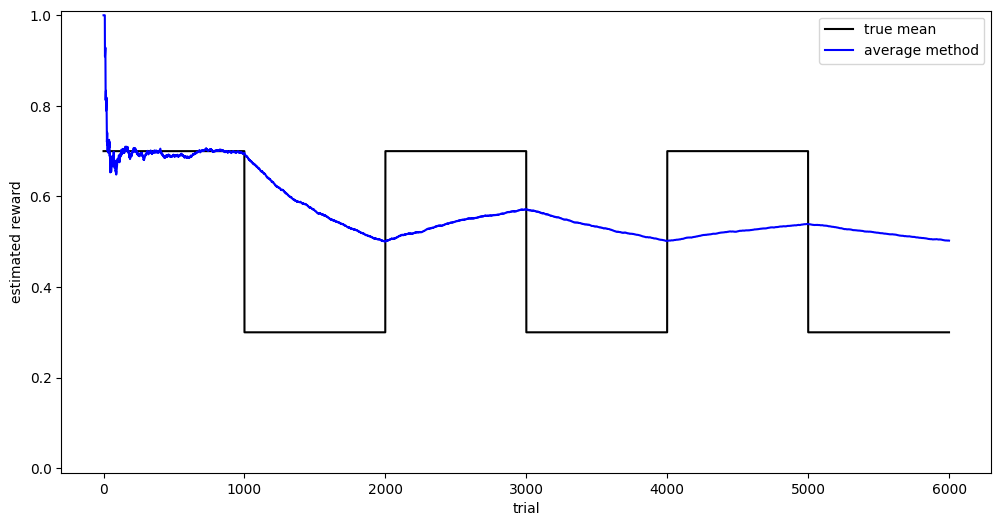

In [60]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(np.arange(len(reward_probs)),reward_probs,'-k',label = 'true mean')
ax.plot(np.arange(len(reward_probs)),mean_avg[0,1:],'-b',label = 'average method')
ax.set_ylim([-0.01,1.01])
plt.legend(loc="upper right")  
ax.set_xlabel('trial')
ax.set_ylabel('estimated reward')

As discussed in the lecture, the _weighted average_ method is often used as an improvement on the average method. The corresponding update rule is as follows:

$V_{t+1} = V_{t} + \alpha(R_{t} - V_{t})$,

where $\alpha$ is the learning rate.

<div class="alert alert-warning" role="alert">
<h2> 3.5 Challenge </h2><br>

The code block below is a copy from the code block above, that simulates an unstable environment and uses the average method to learn the value.

In the code block below, you need to add the estimates of values obatined using the _weighted average_ method. That is, implement the learning rule with the equation in the cell above. Assume a learning rate of 0.05.

</div>

In [61]:
n_trials = 1000
probs = [0.7, 0.3, 0.7, 0.3, 0.7, 0.3]
lr = 0.05                                              # Set learning rate

reward_samples, reward_probs = draw_from_k_bandits(n_trials,probs)

# Simulate a bandit with changing reward probabilities by
# flattening a m-by-n matrix into a 1-by-m*n vector
reward_samples = reward_samples.flatten()
reward_probs = reward_probs.flatten()
# this problem could also be solved by multiple loops

mean_avg = np.empty((1,len(reward_probs)+1))
mean_wgt = np.empty((1,len(reward_probs)+1))   # Add this
for iT in np.arange(len(reward_probs)):    
    if iT==0: #initialize at time point 0
        mean_avg[0,0] = 0.5
        mean_wgt[0,0] = 0.5                            # and this
    #update estimated values    
    mean_avg[0,iT+1] = mean_avg[0,iT] + (1/(iT+1))*(reward_samples[iT]-mean_avg[0,iT])
    mean_wgt[0,iT+1] = mean_wgt[0,iT] + lr*(reward_samples[iT]-mean_wgt[0,iT])            # and this

<div class="alert alert-warning" role="alert">
<h2> 3.6 Challenge </h2><br>

Plot the results again. In your plot, include both the value estimates from the average and the weighted average method. Think about the results for a moment. Which method works better? And why?

And what happens if you increase/decrease the learning rate?
</div>

Text(0, 0.5, 'estimated reward')

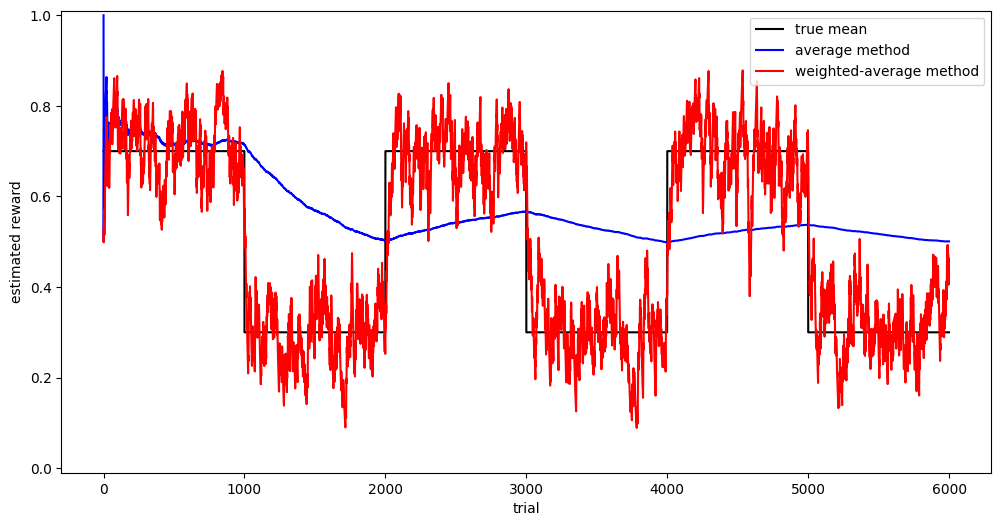

In [62]:
## TODO: Plotting

#print(reward_samples)
#print(mean_avg[0,1:])
#print(mean_wgt[0,1:])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

ax.plot(np.arange(len(reward_probs)),reward_probs,'-k',label = 'true mean')
ax.plot(np.arange(len(reward_probs)),mean_avg[0,1:],'-b',label = 'average method')
ax.plot(np.arange(len(reward_probs)),mean_wgt[0,1:],'-r',label = 'weighted-average method')
ax.set_ylim([-0.01,1.01])
plt.legend(loc="upper right")  
ax.set_xlabel('trial')
ax.set_ylabel('estimated reward')

# 4. Decision rules: Policy

So far, we have only dealt with prediction problems. However, the most powerful application of reinforcement learning lies in solving control problems. 

The decision rule (or policy) defines the agent's way of behaving at a given time or state. This is an extension of the previous prediction problem, as we now also consider actions given each state. Put differently, the policy is a mapping between states and actions and it corresponds to what psychologists sometimes call a stimulus-response association.


### 4.1 Improving decision making... by exploration

In order to replicate the results for the improvement of decision-making as shown in the lecture, we first need to set up a new bandit function.

This new bandit function again takes two input parameters and gives two output variables. In contrast to the previous bandit, the current bandit will draw its reward from a normal (Gaussian) distribution. That means that, contrary to previous bandits that either gave a reward or gave no reward, the new bandits _always_ give a reward, but the amount of reward is continuous follows a Gaussian distribution.


<div class="alert alert-warning" role="alert">
<h2> 4.2 Challenge </h2><br>

Add a function to the routine below that samples rewards from a normal distribution with a mean of <code>mean_rewards</code> and a standard deviation of <code>1</code>. <br>
<br>
    
>HINT: Replace the <code>???</code> in the box below with the appropriate function.

</div>

In [63]:
def draw_from_one_gaussian_bandit(n_trials, mean_reward):
    
    reward_samples = np.random.normal(size=1, loc=mean_reward, scale=1)  # this simulates the rewards
    
    return reward_samples

def draw_from_k_gaussian_bandits(n_trials, mean_rewards):
    
    n_bandits = len(mean_rewards)  # how many arms?
    
    # preallocate output
    reward_samples = np.empty((n_bandits, n_trials))
    reward_probs = np.empty((n_bandits, n_trials))
    
    for i, mean_reward in enumerate(mean_rewards):
        reward_samples[i,:] = draw_from_one_gaussian_bandit(n_trials, mean_reward)
        reward_means[i,:] = mean_reward
        
    return reward_samples, reward_means

During the lecture, we introduced a few different decision rules and of course the list in not exhaustive. Below you find the most commonly used methods:
- random method
- greedy method
- e-greedy method (nb: e is for epsilon)
- softmax method

Let's first implement the different methods for action selection.

In [64]:
def action_random(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    action = np.random.choice(actions)    # this literally just takes a (uniform distributed) random draw
    
    return action

def action_greedy(values):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    ties = np.array(values[:,0] == np.max(values[:,0]))     # here, we find all values that are maximum
    action = np.random.choice(actions[ties])                # and among the maximum values, we choose 1 randomly
    
    return action

def action_epsilon(values,epsilon):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    if (np.random.uniform() < epsilon):
        action = action_random(values)
    else:
        action = action_greedy(values)
    
    return action

Let's make a few assumptions for our simulation first.

In [65]:
n_agents = 100
n_trials = 1000
n_bandits = 10

### 4.3.1 Greedy agents

In the following code block I have set up a number of greedy agents.

In accordance with the lecture, both the average for the rewards (<code>rewards_greedy</code>) and the percentage of optimal decisions (<code>optimum_greedy</code>) will be saved for plotting.

Please note, that we implement the _average methode_ as the learning rule. As this is a stable environment, the properties of the average method guarantee that our estimates converge to the true value (at least with an appropriate action selection method...).

In [66]:
## greedy action selection

rewards_greedy = np.empty((n_agents,n_trials))
optimum_greedy = np.empty((n_agents,n_trials))
for iA in np.arange(n_agents):

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = draw_from_k_gaussian_bandits(n_trials, reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_greedy(values)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        values[action,0] = values[action,0] + (1/action_count[action,0])*PE

        #store reward & optimal decision
        rewards_greedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_greedy[iA,iT] = 1
        else:
            optimum_greedy[iA,iT] = 0

### 4.3.2 $\epsilon$-greedy action selection

Basically, the $\epsilon$-greedy agent is identical to the greedy agent with the the minor detail that on 100*$\epsilon$% of the trials a random action will be chosen.

You find the code for $\epsilon$-greedy actions selection already above.

In [67]:
epsilon = 0.1

rewards_egreedy = np.empty((n_agents,n_trials))
optimum_egreedy = np.empty((n_agents,n_trials))
for iA in np.arange(n_agents): 

    reward_means = np.random.normal(0,1,(n_bandits,1))
    optimal_action = np.argmax(reward_means)
    reward_samples, reward_probs = draw_from_k_gaussian_bandits(n_trials,reward_means)

    #initialize the estimated values for each bandit
    values = np.zeros((len(reward_means),1))
    action_count = np.zeros((len(reward_means),1))
    
    for iT in np.arange(n_trials):    
        #chose action
        action = action_epsilon(values,epsilon)
        action_count[action,0] =  action_count[action,0]+1
        #calculate prediction error
        PE = reward_samples[action,iT]-values[action,0]
        #update value
        values[action,0] = values[action,0] + (1/action_count[action,0])*PE
        
        #store reward
        rewards_egreedy[iA,iT] = reward_samples[action,iT]
        if action == optimal_action:
            optimum_egreedy[iA,iT] = 1
        else:
            optimum_egreedy[iA,iT] = 0     


Now let's plot the results and compare greedy vs epsilon-greedy action selection

Text(0, 0.5, '% optimal choice')

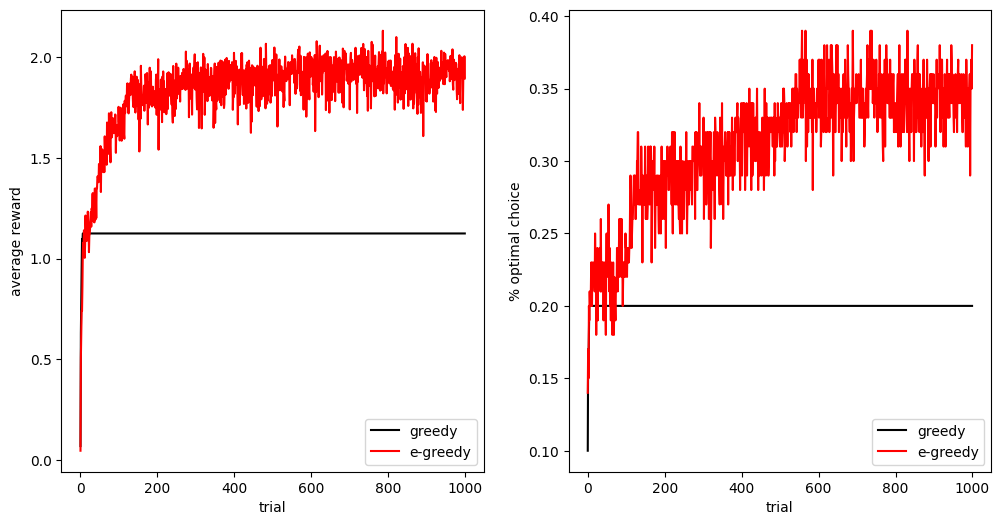

In [68]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.plot(np.arange(n_trials),np.mean(rewards_greedy,0),'-k',label='greedy')
ax.plot(np.arange(n_trials),np.mean(rewards_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right") 
ax.set_xlabel('trial')
ax.set_ylabel('average reward')
ax2 = fig.add_subplot(122)
ax2.plot(np.arange(n_trials),np.mean(optimum_greedy,0),'-k',label='greedy')
ax2.plot(np.arange(n_trials),np.mean(optimum_egreedy,0),'-r',label='e-greedy')
plt.legend(loc="lower right")   
ax2.set_xlabel('trial')
ax2.set_ylabel('% optimal choice')

<div class="alert alert-warning" role="alert">
<h2> 4.3.3 Challenge </h2><br>

Huh, that's strange. These results do not seem to replicate the results from Sutton & Barto. In silico, the $\epsilon$-greedy method should outperform the greedy method for this environment. 
However it does not seem to do so in our simulation.

Can you figure out what's wrong with the code above? Hint: Have a look at the used updating function, and compare it with the correct updating function in the slides.

</div>

### 4.3.4 Softmax action selection

Let's have a closer look at the softmax rule, as this is maybe the most widely used decision rule in the neuroscientific literature.

$\LARGE p(a)= \frac{e ^{(\beta * Q(a))}} {\sum \limits _{a'} e ^{(\beta * Q(a'))}}$ 

In [69]:
def action_softm(values,beta):
    nOptions = len(values)
    actions = np.arange(nOptions)
    
    prob = np.exp(beta*values)/np.sum(np.exp(beta*values))
    action = np.random.choice(actions,size = 1, p = prob) 

    return action, prob

<div class="alert alert-warning" role="alert">
<h2> 4.3.5 Challenge </h2><br>

The central part of the softmax algorithm is missing. Fill in the missing code.
    
>HINT: Use prespecified numpy methods.
</div>

If we want to put this softmax function to use, we can make a few hypothetical assumptions for our bandit task.

For example, let's assume our agent has played the slot machine twice, each arm one time. The left arm lead to a reward (1), whereas the right arm did not result in a reward (0). We can translate this experience into simplified expectations (values) for the next game.

In [70]:
dummy_values = np.array([1,0])
beta = 1

action, prob = action_softm(dummy_values,beta)

print('Chosen action: %d' % (action))
print('Action probablities: %s' % (np.array2string(prob)))

Chosen action: 0
Action probablities: [0.73105858 0.26894142]


We can see, that the dummy expectations translate into action probabilites in a straightforward way. The highest value has the highest action probability.

<div class="alert alert-warning" role="alert">
<h2> 4.3.6 Idea </h2><br>
Play around with the beta value and observe the changes!
    
</div>

As already discussed in the lecture, the beta (or 'inverse temperature') affects the so-called [gain](https://en.wikipedia.org/wiki/Gain_(electronics)). The higher the gain, the more pronounced the differences in action values get translated into action probabilities.

We can plot this in a systematic way.

<div class="alert alert-warning" role="alert">
<h2> 4.3.7 Challenge </h2><br>
Setup a plot similar to the slide in the lecture.<br>
- x-axis: differences in values<br>
- y-axis: action probablity for option 1<br>
    
</div>


In [71]:
betas = [0,1,2,5,10]
x = np.arange(-2,2,0.1)

all_probs = np.empty((len(betas),len(x)))

for i in np.arange(len(betas)):
    for j in np.arange(len(x)):
        values = dummy_values*x[j]
        action,prob = action_softm(values,betas[i]) 
        all_probs[i,j] = prob[0]

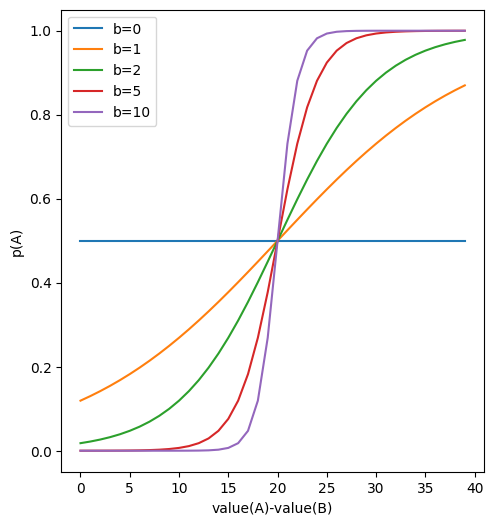

In [72]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.set_prop_cycle
ax.set_xlabel('value(A)-value(B)')
ax.set_ylabel('p(A)')

for i in np.arange(len(betas)):
    ax.plot(np.arange(len(x)),all_probs[i,:],'-',label='b='+str(betas[i]))
plt.legend(loc="upper left")    

<div class="alert alert-success" role="alert">
<h2> Assignment 1: The impact of context (40 points) </h2><br>
Besides the bandits encountered above, we can construct a wide variety of different versions.
    
For example, the type of reward distribution can be varied. We have already encountered _binomial rewards_ in the <code>draw_from_k_bandits</code>. For this bandit, reward distributions indicated the reward probablity associated with each action. We have also already encountered _Gaussian rewards_ in the <code>draw_from_k_gaussian_bandits</code>. Contrary to the binomial rewards, determinstic rewards do not include binomial noise, but Gaussian noise.  

Moreover, we can make a distinction between _stationary (stable)_ and _walking (volatile)_ reward distributions. So far, we have only encountered fixed rewards distributions. Rewards were always drawn from a stable environment and did not change over time. We simulated a walking bandit by generating multiple different walks and glueing them together (flattening). 

For truely walking rewards distributions, noise is added to the defining parameters of the distribution. For example, on every new trial of our <code>draw_from_k_bandits</code>, the new reward probablity could be set to the old rewards probability plus some normal noise with mean 0 and standard deviation 0.05. Please note, that this makes it necessary to define bounds, as rewards probabilities (e.g., binomial) need to be set between 0 and 1. Gaussian rewards should not wander off too much but rather stay between 0 and 100.


> Set up the 4 possible bandits with the following properties (20 points) <br>
> 1. Binomial rewards with fixed reward probabilities (as implemented already in <code>generate_uniform_bandit</code>)
> 2. Binomial rewards with walking reward probabilities
> 3. Gaussian rewards with fixed mean rewards (bound between 0 and 1)
> 4. Gaussian rewards with walking mean rewards (bound between 0 and 1)

> Visualize the bandits. For visualization, use one-armed variants. Plot their true reward probabilites, obtained rewards, etc. (10 points)

> Plot how the performance of our weighted average, softmax RL agents differs between these bandits. For this excersise, use two-armed bandits. For the agent, fix the learning rate (alpha) to 0.1 and the softmax inverse temperature (beta) to 2. (10 points)

</div>

<div class="alert alert-success" role="alert">
<h2> Assignment 2: The interaction of agent and context (30 points) </h2><br>

Environmental change is a crucial aspect that any learning agents has to take into account. We have already seen, how different learning rules (average vs. weighted-average) can be (mal)adaptive, dependent on the environment. Now, we are going to have a closer look into this issue and investigate how the speed of environmental change influences performance of our bandit.     

> Set up a bandit with Gaussian rewards and walking reward probabilities (see bandit option 4 in assignment 1) and add an additional parameter for volatility (i.e., the standard deviation of the normal distribution that governs the _walk_)
    
> Before coding, come up with hypotheses. Would you want your learning rate (alpha) to be high or low in a rapidly changing environment? Would you want your inverse temperature (beta) to be higher or lower in rapidly changing environments? (15 points)
    
> Show how the parameters of our agent is traded-off with different speeds of environmental volatility. Could you verify your intuitions as stated in the hypotheses? (15 points)

    
</div>

<div class="alert alert-success" role="alert">
<h2> Assignment 3: Alternatives to performance (30 points) </h2><br>

So far, we have encountered two measures of performance: 
- Overall or average reward collected by the agent
- proportion of optimal (=greedy) choices
    
There is a another way to look at performance: How well do our expectations of the environment match with the true value of the environment? Put differently, how well do our Q-values track the reward probabilities that generate rewards? The idea is simple: The better our estimate about the true values, the better our decision making will be.
    
> Plot the Q values together with the reward probabilities and compare the performance of the same RL agents for binomial and Gaussian rewards in a walking/changing environment. (15 points)     

A simple metric that you could utilize to quantify performance is the correlation coefficient. High correlation means that Qvalues and true probabilities are aligned, with r=1 indicating a perfect match. Low correlation means that Qvalues and true probabilities are not aligned, with r=0 indicating no connection at all.

> Compare the performance of different agents. Can you manually fine-tune the agent's parameters to optimize correlation?  (15 points)


(Please note that averaging correlation coefficients, e.g. between blocks or agents, is a bit tricky. Use Fisher's z  transformation (<code>numpy.arctanh</code>), average, and then transform back (<code>numpy.tanh</code>), to obtain meaningful results. Alternatively you could also estimate one correlation coefficient for ALL data at once.)

 
</div>

[fisher's z](https://en.wikipedia.org/wiki/Fisher_transformation)<br>



## additional material

For inspiration and more material on reinforcement learning and bandits, see

[link to model-free and model-based RL](https://github.com/ClaireSmid/Model-free_Model-based_Workshop)<br>


[link to recurrent neural networks and RL](https://github.com/kstach01/CogModelingRNNsTutorial)<br>

## Optional: The grid world problem

*Grid worlds* are simplified respresentations of the environment, that are often used for navigation simulation. As is implied by the name, grid worlds break down the environment into a grid, similar to a chess board. For the scope of this course we are going to stick with a very basic 4x4 gridworld.

Before we dive further into the code, a bit more background information on gridworlds. 

Gridworlds are so-called [Markov Decision Processes](https://en.wikipedia.org/wiki/Markov_decision_process). In contrast to the previous bandit task, gridworlds usually are multi-step problems, meaning that actions executed in one state cannot only result in reward, but also affect the upcoming state. This necessitates the agent to not only consider the immediate reward but also the expected cumulative reward. 

```
  ____    ____     ____   ____
  ____    ____     ____   ____

|| s00  |  s01  |  s02 | s03 ||
  ____    ____     ____   ____
    
|| s04  |  s05  |  s06 | s07 ||
  ____    ____     ____   ____
  
|| s08  |  s09  |  s10 | s11 ||
  ____    ____     ____   ____
   
|| s12  |  s13  |  s14 | s15 ||
  ____    ____     ____   ____
  ____    ____     ____   ____
```

Our agent always starts in the same start state (s_0, top left of board). From there, it will take *steps*, that gradually move him across the board. Movement is restricted to the cardinal directions (up, down, right, left). Reward is located in the terminal state (s_15, bottom right of board). Upon arrival at the site of reward, the agent receives the reward (associated with a positive value) and will be returned to the initial state, so the whole procedure can start again. The (time)steps between start and terminal state are regarded as a *run* (or *episode*). Start state, reward and terminal state do NOT change between runs. Thus, our gridworld environment is stable. Also, because each action transitions to a new state with 100% chance, the environment is also considered deterministic.

For this grid world example, we will implement the Q learning rule, which is defined as

$\LARGE Q_{new}(s,a) = Q_{old}(s,a) + \alpha * (R + \gamma max_{a} Q_{old}(s',a) - Q_{old}(s,a))$,

    where $\alpha$ is the learning rate,
    $\gamma$ is the discounting factor,
    and s' is the next state

Below, we define the most basic details for our gridworld.

In [73]:
nTrial = 50 #specify how many times you want to run the q-learning function
nAgent = 10

method = 'egreedy' #options: greedy | egreedy | softmax

alpha = 0.1 #learning rate
beta = 1 #inverse temperature
gamma = 1 # discounting factor
epsilon = 0.1 #parameter for ε-greedy action selection

actions = np.array(['up', 'left', 'down', 'right'])

s_0 = 0 #start state
s_terminal = 15 #final state (goal)

envsize = 4 #size of the environment (n x n)
iZ = 0
states= np.empty([envsize,envsize],dtype=float)
for iY in range(envsize):
    for iX in range(envsize):
        states[iY][iX] = iZ
        iZ +=1
#print('states')
#print(states)        

movecounter = np.empty([nTrial,nAgent] )

### Helper function

Some computational steps have to be performed multiple times.
Here we define those function so we can call them later on in the script.

In [74]:
# this is not an essential package, but it helps us to save variables for visualisation
from copy import deepcopy

In [75]:
def move1step(instate,action):
    
    coords = list(np.where(states == instate))
    
    if (action == 'up'):
        coords[0] -= 1
    if (action == 'down'):
        coords[0] += 1
    if (action == 'left'):
        coords[1] -= 1
    if (action == 'right'):
        coords[1] += 1
        
    if (coords[0] < 0):
        coords[0] = 0
    if (coords[1] < 0):
        coords[1] = 0 
    if (coords[0] >= envsize):
        coords[0] = envsize-1    
    if (coords[1] >= envsize):
        coords[1] = envsize-1
        
    outstate = states[coords[0],coords[1]]   
    return(outstate)  

def getReward(state1,state2):
    if (state2 == s_terminal):
        reward = 10 #final reward at the end of the run
    else:
        reward = 0 #intermediate reward (after each action) 
    if (state1 == state2):
        reward = 0 #reward for running into a wall?
    return reward    

Now that we have defined the most crucial parts for our grid world, we can put everything together.

For convenience, I have already added multiple agents, as this will allow us to draw more precise conclusions from the simulation data.

For the agent's parameters I have implemented very basic values. You can have a look how changing those parameters affects the performance in the grid world.

In [80]:
print('Agent')
for iA in range(nAgent):
    
    print(iA, end=' ')
    Q = np.zeros([len(actions),envsize,envsize] )

    #print('initial Q matrix:\n' + str(Q) + '\n')
    Q0 = deepcopy(Q)

    for iT in range(nTrial): # loop for the different runs
        #if (iT % 100) == 0:
            #print(iT)
        state = s_0
        moves = 0
        while (state != s_terminal): # loop within one run
        
            coord0 = np.where(states == state)

            qvals = Q[:,coord0[0],coord0[1]]
              
            # select action using choice rules
            if (method == 'softmax'):
                pvals = np.exp(beta*qvals)/np.sum(np.exp(beta*qvals))
                action = np.random.choice(actions,size = 1, p = pvals.flatten())            
            elif (method == 'greedy'):
                choices = np.array(qvals == np.max(qvals))
                action = np.random.choice(actions[choices.flatten()])            
            elif (method == 'egreedy'):
                if (np.random.random() < epsilon):
                    action = np.random.choice(actions, size = 1)
                else:
                    choices = np.array(qvals == np.max(qvals))
                    action = np.random.choice(actions[choices.flatten()])
            else:
                action = np.random.choice(actions)
        
            # interact with environment
            next_state = move1step(state,action)
            #print('next state: '+str(next_state))
            reward = getReward(state,next_state)
        
            actionidx = (action==actions)
            coord1 = np.where(states == next_state) 
        
            # update expectations using learing rules
            Q[actionidx,coord0[0],coord0[1]] = Q[actionidx,coord0[0],coord0[1]] + alpha * (reward + gamma * np.max(Q[:,coord1[0],coord1[1]]) - Q[actionidx,coord0[0],coord0[1]])
        
            if ((iT == 0) and (next_state == s_terminal)):
                #print('Q matrix before first successful run:\n' + str(Q) + '\n')
                Q1 = deepcopy(Q)
        
            # update variables
            state = next_state
            moves += 1
        
        #end of while loop
        movecounter[iT,iA] = moves
    #end of trial for loop
    #print('final Q matrix:\n' + str(Q) + '\n')
    Q2 = deepcopy(Q)
#end of agent for loop
#print('\n\nFinal Q(s,a) for agent '+str(iA))
#print(Q)

Agent
0 1 2 3 4 5 6 7 8 9 

In order to better understand the agents' behavior in the gridworld we can again make use of the `print()` and `plot()` function.

<div class="alert alert-warning" role="alert">
<h2> Questions </h2><br>
Before we continue, think about the performance of our agent. Do you have any hypothesis about this? What would you expect from a RL agent? How should his behavior change?
    
</div>

In the following sections we will try to answer those questions.

### Plotting performance

**Question:** What is our hypothesis for the performance of our agent?

**Answer:** Performance for learning agents should improve over time. Therefore we should expect to find improvements in performance for our grid world agent. Performance can be measured in multiple different ways. For our grid world example, we could define performance as is already plotted below: the number of steps it takes the agents to get from start state to terminal state. While the agent is aimlessly roaming the gridworld in the beginning, it quickly picks up the optimal path to the goal.

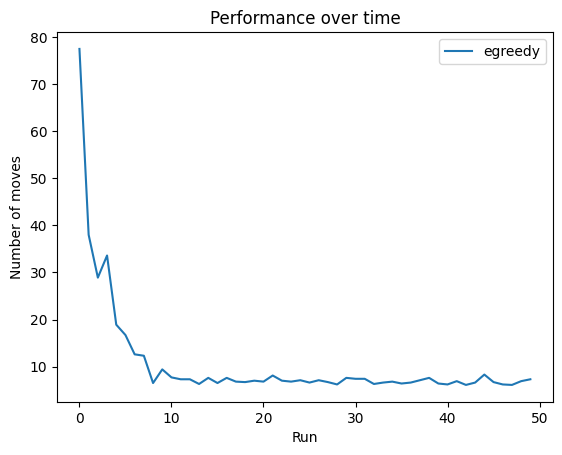

In [77]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.

xdata = range(nTrial)
ydata = np.mean(movecounter,axis=1)

ax.plot(xdata, ydata, label = method)  # Plot some data on the axes.

ax.set_title('Performance over time')
ax.set_xlabel('Run')
ax.set_ylabel('Number of moves')
ax.legend()

### Plotting values and policies

We can also visualize the state and action values of our gridworld. 

In [78]:
Qmat0 = np.max(Q0,axis=0)
Qmat1 = np.max(Q1,axis=0)
Qmat2 = np.max(Q2,axis=0)

print(Qmat0)
print(Qmat1)
print(Qmat2)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]
[[3.47159158 5.30692883 7.17763982 1.33513535]
 [0.         0.56558429 8.67707347 9.5645619 ]
 [0.         0.         2.48242918 9.92144833]
 [0.01       0.28       3.439      0.        ]]


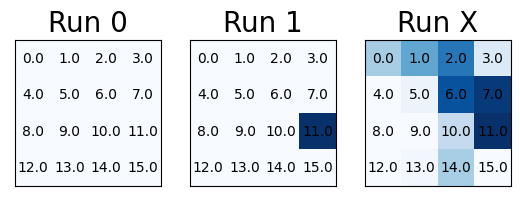

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

layout = [['s0', 's5/6'], ['s1', 's4'], ['s2', 's3']]

min_val, max_val = -1, 10

for i in range(envsize):
    for j in range(envsize):
        ax1.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax2.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
        ax3.text(i, j, str(states[j][i]), va='center', ha='center',size=10)
ax1.matshow(Qmat0, cmap=plt.cm.Blues)  
ax2.matshow(Qmat1, cmap=plt.cm.Blues)
ax3.matshow(Qmat2, cmap=plt.cm.Blues)

ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)

ax1.title.set_text('Run 0')
ax1.title.set_size(20)
ax2.title.set_text('Run 1')
ax2.title.set_size(20)
ax3.title.set_text('Run X')
ax3.title.set_size(20)


<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
The current grid world is perfectly deterministic. Actions reliably lead to the same outcome. Reward is always hidden in the same location. Recall that for our bandit example reward delivery was probabilistic. Can you implement some randomness in the grid world as well? Think about a few possible options. How could you implement those and what would be the consequences for agents' learning and decision-making?<br>
    
>Discuss your ideas with the workgroup teacher!
    
</div>

<div class="alert alert-success" role="alert">
<h2> Ideas for individual assignments </h2><br>
So far, we have only implemented different decision rules at this point. But we could also think about different learning rules. As discussed in the lecture, a prominent example from Sutton & Barto (2018, p.132) is the cliff world. In their variant of the grid world, learning for the different learning rules translates into very distinct behavioral patterns. It nicely illustrates how small changes in the algorithm can have quite strong effects on decision making. Have a look at the example. Can you construct a cliff world and replicate the findings reported by Sutton & Barto? <br> 
    
>Discuss your ideas with the workgroup teacher!
</div>